This notebook exemplifies TME (in SymPy) on a Benes model.

$
d X(t) = \mathrm{tanh}(X(t)) dt + dW(t).
$

We want to compute its mean and variance as well as some non-linear expectations, such as

$
\mathbb{E}[\sin(X(t)) \mid X(t_0)]
$

by using the TME method.

First, you need to have the package `tme` installed.

In [16]:
import math
import sympy as sp
import numpy as np
import tme.base_sympy as tme

import matplotlib.pyplot as plt

from sympy import lambdify
from typing import Callable

In order to measure the TME approximation accuracy, we use these functions to compute the expectations above exactly by Rieman integrations.

In [17]:
def rieman1D(x: np.ndarray,
             f: Callable,
             *args, **kwargs):
    r"""Riemannian computation of an integral
    \int f(x, *args, **kwargs) dx \approx \sum f(x_i) (x_i - x_i-1)
    """
    return np.sum(f(x[1:], *args, **kwargs) * np.diff(x))

def benesPDF(x: np.ndarray,
             x0: float,
             dt: float):
    """
    Transition density of the Benes model.
    See, pp. 214 in Sarkka 2019.
    """
    return 1 / math.sqrt(2 * math.pi * dt) * np.cosh(x) / np.cosh(x0) \
           * math.exp(-0.5 * dt) * np.exp(-0.5 / dt * (x - x0) ** 2)

def f_mean(x: np.ndarray,
           x0: float,
           dt: float):
    return x * benesPDF(x, x0, dt)


def f_x2(x: np.ndarray,
         x0: float,
         dt: float):
    return x ** 2 * benesPDF(x, x0, dt)

def f_sin(x: np.ndarray,
          x0: float,
          dt: float):
    return np.sin(x) * benesPDF(x, x0, dt)

Now, in order to use TME (in SymPy), the first step is to make symbols of the Benes SDE in SymPy.

In [18]:
x = sp.MatrixSymbol('x', 1, 1)
a = sp.Matrix([sp.tanh(x[0])])
b = sp.eye(1)
Qw = sp.eye(1)
dt_sym = sp.Symbol('dt', positive=True)

Then, we bring in TME and lambdify the results (i.e., make the symbolic results "numpy" functons).

In [19]:
# Get the mean and cov symbolc results with expansion order 3 and simplification.
mean, var = tme.mean_and_cov(x=x, a=a, b=b, Qw=Qw, dt=dt_sym, 
                             order=3, simp=True)
Esin = tme.expectation(sp.Matrix([sp.sin(x[0])]), 
                       x=x, a=a, b=b, Qw=Qw, dt=dt_sym, 
                       order=3, simp=True)

# Next, we need to convert the symbolic results into numpy functions for numerical computations.
# The converted functions accept two arguments: x and dt.
mean_func = lambdify([x, dt_sym], mean, 'numpy')
var_func = lambdify([x, dt_sym], var, 'numpy')
Esin_func = lambdify([x, dt_sym], Esin, 'numpy')

The mean and var solutions from TME-3 are exact, which we could also see later in the plot.

In [20]:
mean, var

(Matrix([[dt*tanh(x[0, 0]) + x[0, 0]]]),
 Matrix([[1.0*dt*(-dt*tanh(x[0, 0])**2 + dt + 1)]]))

Next we can compute the expectations, and let's also compare with numerically exact solutions.

In [21]:
np.random.seed(666)

x0 = 0.5

# Generate time instances
num_measurements = 200
T = np.linspace(0.01, 4, num_measurements)

# Result containers
mean_results = np.zeros((num_measurements, ))
var_results = np.zeros((num_measurements, ))
Esin_results = np.zeros((num_measurements, ))

# Compute TME for every t in T by calling the generated functions above
for idx, t in enumerate(T):
    mean_results[idx] = mean_func(np.array([[x0]]), np.array([[t]]))
    var_results[idx] = var_func(np.array([[x0]]), np.array([[t]]))
    Esin_results[idx] = Esin_func(np.array([[x0]]), np.array([[t]]))
    
# Compute the mean and variance by numerical integration
# Riemannian range
range_dx = np.linspace(x0 - 20, x0 + 20, 100000)

riem_mean_results = np.zeros((num_measurements, ))
riem_var_results = np.zeros((num_measurements, ))
riem_Esin_results = np.zeros((num_measurements, ))

for idx, t in enumerate(T):
    riem_mean_results[idx] = rieman1D(range_dx, f_mean, x0=x0, dt=t)
    riem_var_results[idx] = rieman1D(range_dx, f_x2, x0=x0, dt=t) - riem_mean_results[idx] ** 2
    riem_Esin_results[idx] = rieman1D(range_dx, f_sin, x0=x0, dt=t)

Finally let us plot the results. We can see that, for

Text(0.5, 1.0, 'Approximation for variance.')

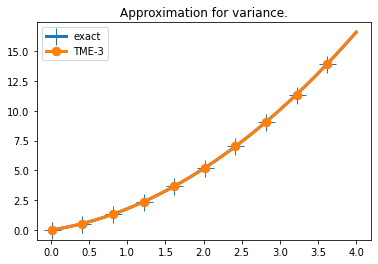

In [23]:
plt.plot(T, riem_var_results, 
         linewidth=3, marker='+', markevery=20, markersize=17, 
         label='exact')
plt.plot(T, var_results,
         linewidth=3, marker='.', markevery=20, markersize=17,
         label='TME-3')
plt.legend(loc='upper left')
plt.title('Approximation for variance.')

Text(0.5, 1.0, 'Approximation for E[sin(X(t))].')

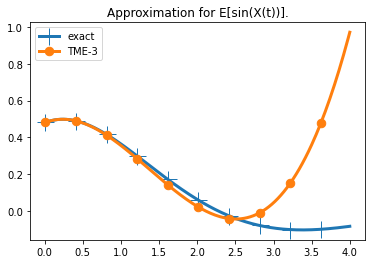

In [24]:
plt.plot(T, riem_Esin_results, 
         linewidth=3, marker='+', markevery=20, markersize=17, 
         label='exact')
plt.plot(T, Esin_results,
         linewidth=3, marker='.', markevery=20, markersize=17,
         label='TME-3')
plt.legend(loc='upper left')
plt.title('Approximation for E[sin(X(t))].')